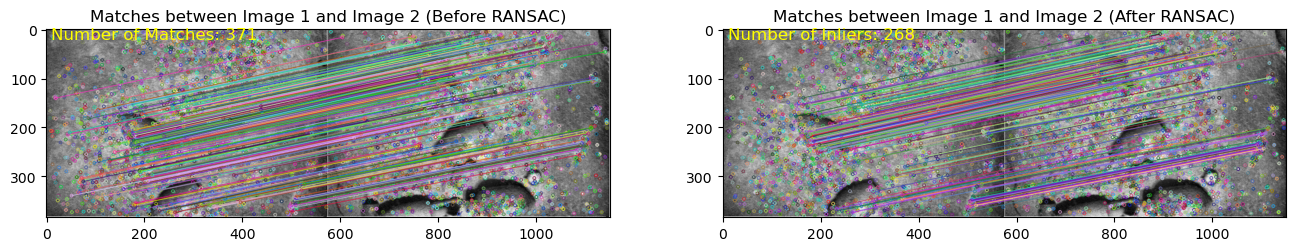

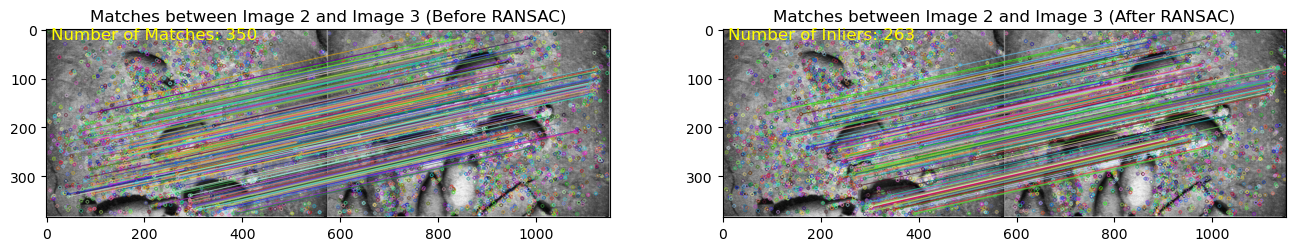

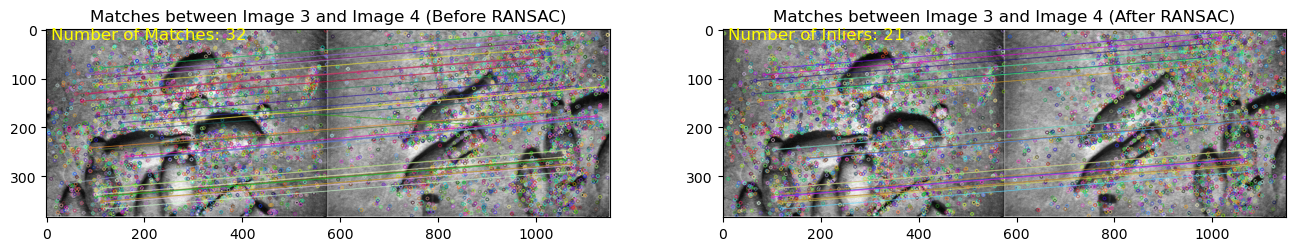

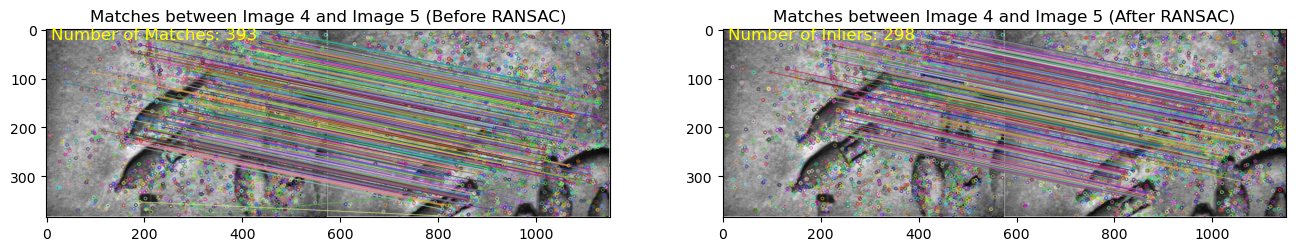

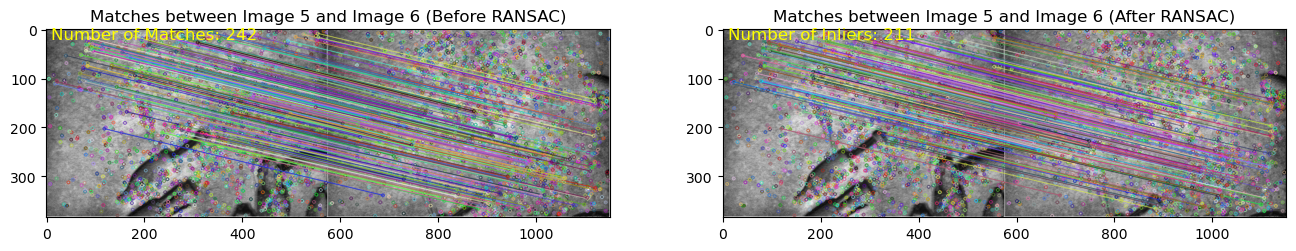

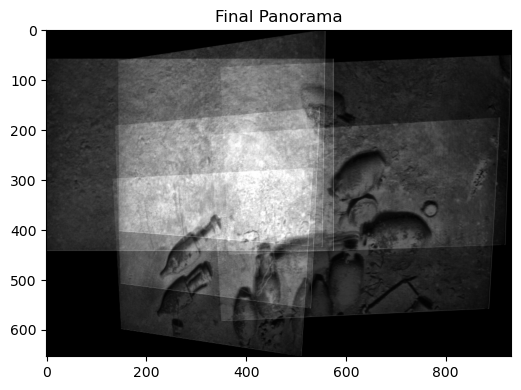

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Folder containing image pairs
# image_folder = 'E:/AFR/HW#3/6Images'
image_folder = 'Images/6Images'

# Get a list of image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.tif', '.bmp'))]

# Sort the image files to ensure they are in the correct order
image_files.sort()  # Sort the image files

# Initialize an empty list to store the loaded and normalized images
images = []

# Initialize CLAHE (Contrast Limited Adaptive Histogram Equalization)
# Increase cliplimit helps in panorama (default is 2)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  # Adjust parameters as needed

# Load and enhance each image file individually
for img_file in image_files:
    img_path = os.path.join(image_folder, img_file)
    image = cv2.imread(img_path)

    # Apply CLAHE for local contrast enhancement
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    l_channel = clahe.apply(l_channel)
    enhanced_lab_image = cv2.merge((l_channel, a_channel, b_channel))
    enhanced_image = cv2.cvtColor(enhanced_lab_image, cv2.COLOR_LAB2BGR)

    images.append(enhanced_image)

# Initialize empty canvases for the left panorama
height, width, _ = images[0].shape
panorama_size = (width * 2, height * len(images))

# Initialize blank canvas for the final panorama
stitched_panorama = np.zeros((panorama_size[1], panorama_size[0], 3), np.uint8)

# Initialize lists to store keypoints and descriptors for each image
keypoints_list = []
descriptors_list = []

# Create a SIFT detector
sift = cv2.SIFT_create(nfeatures=4000, nOctaveLayers=12, contrastThreshold=0.025, sigma=1.5)

# Initialize an identity matrix as the cumulative homography matrix
cumulative_homography = np.eye(3)

# Initialize translation matrix
translation = np.array([[1, 0, panorama_size[0] / 2], [0, 1, panorama_size[1] / 2], [0, 0, 1]])

# Initialize updated homographies list
updated_homographies = []

# Create masks for each image
masks = []
for image in images:
    mask = np.zeros_like(image, dtype=np.uint8)
    mask[image.sum(axis=2) > 0] = 255
    masks.append(mask)

# Detect keypoints and compute descriptors for each image
for image in images:
    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(image, None)

    # Append keypoints and descriptors to the lists
    keypoints_list.append(keypoints)
    descriptors_list.append(descriptors)

# Iterate through the remaining images to stitch them together
for i in range(len(images) - 1):
    # Match descriptors between the current image and the base image
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors_list[i], descriptors_list[i + 1], k=2)

    # Apply ratio test to select good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    # Check if there are enough good matches to calculate the homography
    if len(good_matches) < 4:
        print(f"Image {i + 1} - Not enough good matches for homography.")
        continue

    # Calculate the homography matrix
    dst_pts = np.float32([keypoints_list[i][m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    src_pts = np.float32([keypoints_list[i + 1][m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    homography, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5)
    
    inliers = mask.ravel().tolist()
    
     # Visualize matches before RANSAC
    before_ransac = cv2.drawMatches(images[i], keypoints_list[i], images[i + 1], keypoints_list[i + 1], good_matches, outImg=None)
    
    # Visualize matches after RANSAC (inliers)
    after_ransac = cv2.drawMatches(images[i], keypoints_list[i], images[i + 1], keypoints_list[i + 1], good_matches, outImg=None, matchesMask=inliers)
    
    # Create subplots
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.title(f'Matches between Image {i + 1} and Image {i + 2} (Before RANSAC)')
    plt.text(10, 20, f'Number of Matches: {len(good_matches)}', color='yellow', fontsize=12)
    plt.imshow(cv2.cvtColor(before_ransac, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 2, 2)
    plt.title(f'Matches between Image {i + 1} and Image {i + 2} (After RANSAC)')
    plt.text(10, 20, f'Number of Inliers: {(np.sum(inliers))}', color='yellow', fontsize=12)
    plt.imshow(cv2.cvtColor(after_ransac, cv2.COLOR_BGR2RGB))

    plt.show()

    # Update the cumulative homography matrix
    cumulative_homography = np.dot(cumulative_homography, homography)

    # Update the translation matrix
    updated_homography = np.dot(translation, cumulative_homography)
    updated_homographies.append(updated_homography)

   # Warp the current image using the updated homography
    temp = cv2.warpPerspective(images[i+1], updated_homography, panorama_size)

    # Blend the images using the masks
    stitched_panorama = cv2.addWeighted(stitched_panorama, 0.9, temp, 0.35, 0)

    
# Calculate the translation for the last image
last_image_translation = np.array([[1, 0, cumulative_homography[0, 2] -150 + panorama_size[0] / 2], [0, 1, cumulative_homography[1, 2] + panorama_size[1] / 2], [0, 0, 1]])

# Warp the last image using the updated translation matrix
last_image = cv2.warpPerspective(images[-1], last_image_translation, panorama_size)

stitched_panorama = cv2.addWeighted(stitched_panorama, 0.9, last_image, 0.35, 0)

# Finding appropriate bounding box
yy, xx = np.where(stitched_panorama.sum(axis=2) > 0)
x_min, x_max = np.min(xx), np.max(xx)
y_min, y_max = np.min(yy), np.max(yy)

# Crop the panorama to the bounding box region
stitched_panorama = stitched_panorama[y_min:y_max, x_min:x_max]

# Display the final panorama
plt.figure(figsize=(6, 6))
plt.title('Final Panorama')
plt.imshow(cv2.cvtColor(stitched_panorama, cv2.COLOR_BGR2RGB))
plt.show()
